In [1]:
import pandas as pd                         # pandas 
import pandas_datareader.data as pdr        # 株価などのdataを引っ張れる
from datetime import datetime               # 日時を扱う
from datetime import timedelta
import numpy as np                          # ちょっとした計算をする
import scipy.optimize as sco                # 最適化する
from bokeh.io import output_notebook        # グラフを作る（）
from bokeh.plotting import figure, show     # グラフを作る
%matplotlib inline
output_notebook()

Loading BokehJS ...

## 長期運用の資産配分をPythonを使ってやってみよう
   
### 皆さん自分の資産運用してますか？
* 年金とか頼ってないですよね？   
ZEROHEDGE ["The Ponzi Scheme That's Over ×100 The Size Of Madoff."](http://www.zerohedge.com/news/2017-11-10/ponzi-scheme-thats-over-100x-size-madoff)
* Ponzi Scheme == ネズミ講  
* Madoff == [バーナンド・マドフ](https://www.google.co.jp/search?q=%E3%83%90%E3%83%BC%E3%83%8A%E3%83%B3%E3%83%89+%E3%83%9E%E3%83%89%E3%83%95&oq=%E3%83%90%E3%83%BC%E3%83%8A%E3%83%B3%E3%83%89%E3%80%80%E3%83%9E%E3%83%89%E3%83%95&aqs=chrome..69i57j0l5.7523j0j4&sourceid=chrome&ie=UTF-8)   
  年１０％儲かる絶対的な投資法を見つけたと言って６５０億ドル（７兆円）集めた。   
  自分で証券会社を作って、NASDAQの会長もやっていたため信用力があった。
* その１００倍のネズミ講って何？　 == 年金(pension fund)

### ロボアドバイザーとか頼ってみる？
* グーグルの一番に推してくる[Wealth Navi](https://invest.wealthnavi.com/simulation?_ga=2.39836323.1452126704.1512784495-1105591666.1512784495&_gac=1.222479849.1512784495.CjwKCAiAjanRBRByEiwAKGyjZWrJ-AgrnjPLBZR7K-8NTcRKlQJG2Z-5kMVS4WtKgJyO-6WF6vJB6RoCP0sQAvD_BwE)
* まぁ手数料をたくさん払うより良いかもしれない。
* しかし、酔っぱらいみたいな質問して適当に資産配分を推し進めてきます。
* そんなものに頼れない。でも金融屋はもっと信用できない！

# じゃあ自分で作ってみれば？？？


### 参考にするのは東京のfinpyで発表があったものです。  
* Scipyで２次計画問題を解く　　〜ポートフォリオ最適化の例   
https://qiita.com/ryoshi81/items/b323a363e5442a15db6d
* これに債券を加えたり妄想資産を追加したりしてみます。
* 自分で作ってコストを抑えよう！　長期投資でネックとなるのは資産配分とコストです！
   
   
## 自分で資産のリスク／リターンを計算する
### 株だけを見てみる
* pandas_datareaderを使って株価を取得する
* ローソク足を作る
* リスクやリターンを作る(年率)
* 資産間の相関を見る

### アセット・アロケーションを取り扱う
* ポートフォリオ

pandas datareader ドキュメント   
https://pandas-datareader.readthedocs.io/en/latest/

In [2]:
apple = pdr.get_data_yahoo('AAPL')

In [3]:
apple.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-12-31,30.447144,30.478571,30.080000,30.104286,26.986492,88102700
2010-01-04,30.490000,30.642857,30.340000,30.572857,27.406532,123432400
2010-01-05,30.657143,30.798571,30.464285,30.625713,27.453915,150476200
2010-01-06,30.625713,30.747143,30.107143,30.138571,27.017223,138040000
2010-01-07,30.250000,30.285715,29.864286,30.082857,26.967278,119282800


In [4]:
type(apple.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [5]:
apple_w = apple.resample('W').last()
apple_w.index = pd.to_datetime(apple_w.index)

In [6]:
apple_w.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-19,171.039993,171.389999,169.639999,170.149994,170.149994,21899500
2017-11-26,175.100006,175.500000,174.649994,174.970001,174.970001,14026700
2017-12-03,169.949997,171.669998,168.500000,171.050003,171.050003,39759300
2017-12-10,170.490005,171.000000,168.820007,169.369995,169.369995,23355200
2017-12-17,172.399994,173.130005,171.649994,172.220001,172.220001,19928796


In [7]:
tools = "hover, pan, wheel_zoom, box_zoom, reset"

p = figure(x_axis_type='datetime', width=800, height=500, tools = tools, title='アップルの株価')

inc = apple_w['Close'] > apple_w['Open']
dec = apple_w['Close'] < apple_w['Open']
w = 24 * 60 * 60 * 10000

p.segment(apple_w.index, apple_w['High'], apple_w.index, apple_w['Low'], color='black')
p.vbar(apple_w.index[inc], w, apple_w['Close'][inc], apple_w['Open'][inc], fill_color='red', line_color='black')
p.vbar(apple_w.index[dec], w, apple_w['Close'][dec], apple_w['Open'][dec], fill_color='blue', line_color='black')

show(p)

## 26週の移動平均線を足してみる

In [8]:
apple_w['26_w'] = apple_w['Close'].rolling(26).mean()

In [9]:
tools = "hover, pan, wheel_zoom, box_zoom, reset"

p = figure(x_axis_type='datetime', width=800, height=500, tools = tools, title='アップルの株価')

inc = apple_w['Close'] > apple_w['Open']
dec = apple_w['Close'] < apple_w['Open']
w = 24 * 60 * 60 * 10000

p.segment(apple_w.index, apple_w['High'], apple_w.index, apple_w['Low'], color='black')
p.vbar(apple_w.index[inc], w, apple_w['Close'][inc], apple_w['Open'][inc], fill_color='red', line_color='black')
p.vbar(apple_w.index[dec], w, apple_w['Close'][dec], apple_w['Open'][dec], fill_color='blue', line_color='black')

p.line(apple_w.index, apple_w['26_w'], line_color='pink')

show(p)

In [10]:
apple_w['chg'] = apple_w['Close'].pct_change()

In [11]:
apple_w.head()

,Open,High,Low,Close,Adj Close,Volume,26_w,chg
Date,,,,,,,,
2010-01-03,30.447144,30.478571,30.080000,30.104286,26.986492,88102700,NaN,NaN
2010-01-10,30.042856,30.285715,29.865715,30.282858,27.146566,111902700,NaN,0.005932
2010-01-17,30.132856,30.228571,29.410000,29.418571,26.371792,148516900,NaN,-0.028540
2010-01-24,29.540001,29.642857,28.165714,28.250000,25.324244,220441900,NaN,-0.039722
2010-01-31,28.725714,28.885714,27.178572,27.437143,24.595573,311488100,NaN,-0.028774


In [12]:
apple.index[-1] - apple.index[0]

Timedelta('2905 days 00:00:00')

In [13]:
ap_dt = apple_w.index[-1] - apple_w.index[0]

In [14]:
year = timedelta(days = 365) # 1年の日数

In [15]:
ap_dt / year

7.958904109589041

In [16]:
ap_yr = ap_dt / year  # データを読み込んだ期間を年で出す

In [17]:
rets = (1 + ((apple_w.iloc[-1, 4] - apple_w.iloc[0, 4])/ apple_w.iloc[0, 4])) **(1 / ap_yr) - 1 # アップル株の年率リターン

In [18]:
rets 

0.26222472172825828

In [19]:
(apple_w.iloc[-1, 4] - apple_w.iloc[0, 4]) / apple_w.iloc[0, 4]

5.381711302084021

In [20]:
vol = apple_w['chg'].std() * np.sqrt(52) # 年率の標準偏差を求める

In [21]:
vol

0.26875208992577648

In [22]:
rol_vol = apple_w['chg'].rolling(52).std() * np.sqrt(52)

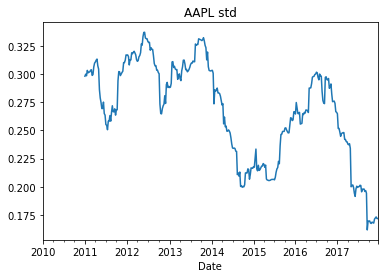

In [23]:
rol_vol.plot(title='AAPL std')

## 資産間のcorrelationを求める
* アップルと日経平均株価で求めてみる

In [24]:
nky = pdr.get_data_yahoo('^N225')

In [25]:
nky.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,10609.339844,10694.490234,10608.139648,10654.790039,10654.790039,104400.0
2010-01-05,10719.440430,10791.040039,10655.570313,10681.830078,10681.830078,166200.0
2010-01-06,10709.549805,10768.610352,10661.169922,10731.450195,10731.450195,181800.0
2010-01-07,10742.750000,10774.000000,10636.669922,10681.660156,10681.660156,182600.0
2010-01-08,10743.299805,10816.450195,10677.559570,10798.320313,10798.320313,211800.0


In [26]:
nky_w = nky.resample('W').last()
nky_w['chg'] = nky_w['Adj Close'].pct_change()
change = pd.concat([apple_w['chg'], nky_w['chg']], axis=1) # concatはデータフレーム同士を結合したりする時に使う

In [27]:
change.tail()

,chg,chg
Date,,
2017-11-19,-0.025877,-0.012549
2017-11-26,0.028328,0.006878
2017-12-03,-0.022404,0.011892
2017-12-10,-0.009822,-0.000348
2017-12-17,0.016827,-0.005113


In [28]:
change.columns = ['apple', 'nky']

In [29]:
change = change.dropna()

In [30]:
change.corr() #

,apple,nky
apple,1.000000,0.329196
nky,0.329196,1.000000


In [31]:
change['corr_52w'] = change['apple'].rolling(52).corr(change['nky'])

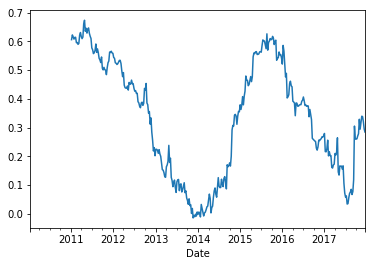

In [32]:
change['corr_52w'].plot()

### matplotlibの日本語豆腐化問題
フォントを入れれば解決できるらしいが面倒くさいので、bokehに走る！   
でもgithubでbokeh表示してくれないかも。

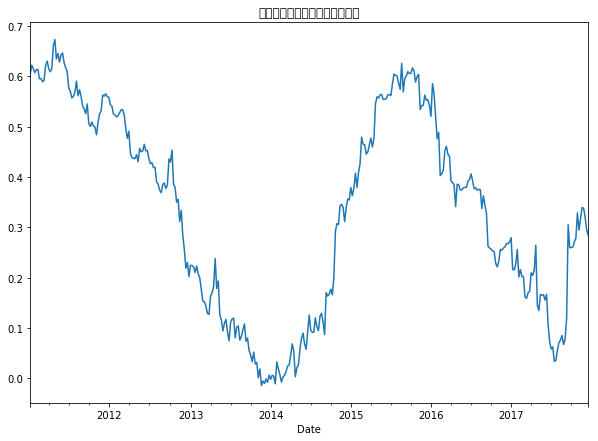

In [33]:
change['corr_52w'].dropna().plot(figsize=(10,7), title='アップルと日経平均株価の相関')

In [34]:
p = figure(x_axis_type='datetime', width=800, height=500, title='アップルと日経平均株価の相関')

p.line(change.index, change['corr_52w'], color='blue')

show(p)

## ちなみに
* githubにjupyter notebook + bokehのチャートを共有しようとすると出てきません。
* bokehがjavascriptで動いているからのようです。
* そのためnbviewerでnotebookをhtmlとして出力する必要があります。
* nbviewer  https://nbviewer.jupyter.org/
* jupyter notebook, pandas , matplotlib, bokeh をよく知れる本  
### PythonユーザのためのJupyter[実践]入門    
  https://www.amazon.co.jp/Python%E3%83%A6%E3%83%BC%E3%82%B6%E3%81%AE%E3%81%9F%E3%82%81%E3%81%AEJupyter-%E5%AE%9F%E8%B7%B5-%E5%85%A5%E9%96%80-%E6%B1%A0%E5%86%85-%E5%AD%9D%E5%95%93/dp/4774192236/ref=sr_1_1?ie=UTF8&qid=1513042698&sr=8-1&keywords=jupyter

## ポートフォリオ

* 色々な資産を組み合わせて作ります。
* ただ単に組み合わせるだけでなく、できるだけ低いリスクで大きなリターンを得られることを目指します。  
* そのために必要なのが、
     * リターン
     * リスク
     * 相関
です。そのためにその計算方法を先に見ました。    
    
#### でも今回は計算しません。   
→ 理由   
    債券のパフォーマンスを見られる指数がネットでは見られない。       
    
なので、我々の年金を運用するGPIFのサイトの資料を使います。    
GPIFのサイト   
http://www.gpif.go.jp/     
基本ポートフォリオ    
http://www.gpif.go.jp/operation/foundation/portfolio.html    
ポートフォリオの中期計画の変更    
http://www.gpif.go.jp/operation/foundation/pdf/midterm_plan_change.pdf

### 国内債券、国内株式、外国債券、外国株、短期資産

In [35]:
rets = [0.03, 0.048, 0.032, 0.05, 0.019]    # リターン（年率）
vols = [0.065, 0.2248, 0.129, 0.2248, 0.039]   # 標準偏差（リスク）


In [36]:
corrs = [[1, 0.199, -0.025, 0.001, 0.504],
        [0.199, 1, -0.063, 0.494, 0.096],
        [-0.025, -0.063, 1, 0.577, 0.009],
        [0.001, 0.494, 0.577, 1, -0.022],
        [0.504, 0.096, 0.009, -0.022, 1]]  # 相関係数

# まずは相関係数を共分散に直します
* 理由　参考にしている　@ryoshi81さんの記事で相関係数を使わずに共分散を使っているため。
* 相関係数を使ったやり方を調べるのが面倒でした。すみません。
* 相関係数（x, y) = 共分散(x, y) / (標準偏差x * 標準偏差y) 

In [37]:
corrs[0]

[1, 0.199, -0.025, 0.001, 0.504]

In [38]:
a1 = []
a2 = []
a3 = []
a4 = []
a5 = []

In [39]:
def testi(k=0.065, box = a1, volla=vols): #共分散作る関数
    for i in range(len(volla)):
        box.append(k*volla[i])

In [40]:
testi(k=0.065, box= a1)
testi(k=0.2248, box= a2)
testi(k=0.129, box= a3)
testi(k=0.2248, box= a4)
testi(k=0.039, box= a5)

In [41]:
print(a1, a2, a3, a4, a5)

[0.0042250000000000005, 0.014612, 0.008385, 0.014612, 0.002535] [0.014612, 0.05053504, 0.0289992, 0.05053504, 0.0087672] [0.008385, 0.0289992, 0.016641, 0.0289992, 0.005031] [0.014612, 0.05053504, 0.0289992, 0.05053504, 0.0087672] [0.002535, 0.0087672, 0.005031, 0.0087672, 0.001521]


In [42]:
covp = [np.array(a1) * np.array(corrs[0]), np.array(a2) * np.array(corrs[1]), \
        np.array(a3) * np.array(corrs[2]), np.array(a4) * np.array(corrs[3]), \
        np.array(a5) * np.array(corrs[4])]

In [43]:
covp = np.array(covp)

In [44]:
covp

array([[  4.22500000e-03,   2.90778800e-03,  -2.09625000e-04,
          1.46120000e-05,   1.27764000e-03],
       [  2.90778800e-03,   5.05350400e-02,  -1.82694960e-03,
          2.49643098e-02,   8.41651200e-04],
       [ -2.09625000e-04,  -1.82694960e-03,   1.66410000e-02,
          1.67325384e-02,   4.52790000e-05],
       [  1.46120000e-05,   2.49643098e-02,   1.67325384e-02,
          5.05350400e-02,  -1.92878400e-04],
       [  1.27764000e-03,   8.41651200e-04,   4.52790000e-05,
         -1.92878400e-04,   1.52100000e-03]])

In [45]:
def min_fanc_var(weights):
    return np.dot(weights.T, np.dot(covp, weights))  # 最小化する目的関数を作る

In [46]:
x0 = [1. / len(rets)] * len(rets)  # 初期解　　最初に全部の資産に同じ比率で投資するってのを作っています

In [47]:
x0

[0.2, 0.2, 0.2, 0.2, 0.2]

In [48]:
bnds = [(0, None)] * len(rets)  # 投資の上限下限を決めています。マイナスにならないようにしている。ので資産配分が１００％以上にもなりません。

In [49]:
bnds

[(0, None), (0, None), (0, None), (0, None), (0, None)]

In [50]:
max_ret = np.array(rets).max().round(3)
min_ret = np.array(rets).min().round(3)
trets = np.linspace(min_ret, max_ret, 100)

In [51]:
trets

array([ 0.019     ,  0.01931313,  0.01962626,  0.01993939,  0.02025253,
        0.02056566,  0.02087879,  0.02119192,  0.02150505,  0.02181818,
        0.02213131,  0.02244444,  0.02275758,  0.02307071,  0.02338384,
        0.02369697,  0.0240101 ,  0.02432323,  0.02463636,  0.02494949,
        0.02526263,  0.02557576,  0.02588889,  0.02620202,  0.02651515,
        0.02682828,  0.02714141,  0.02745455,  0.02776768,  0.02808081,
        0.02839394,  0.02870707,  0.0290202 ,  0.02933333,  0.02964646,
        0.0299596 ,  0.03027273,  0.03058586,  0.03089899,  0.03121212,
        0.03152525,  0.03183838,  0.03215152,  0.03246465,  0.03277778,
        0.03309091,  0.03340404,  0.03371717,  0.0340303 ,  0.03434343,
        0.03465657,  0.0349697 ,  0.03528283,  0.03559596,  0.03590909,
        0.03622222,  0.03653535,  0.03684848,  0.03716162,  0.03747475,
        0.03778788,  0.03810101,  0.03841414,  0.03872727,  0.0390404 ,
        0.03935354,  0.03966667,  0.0399798 ,  0.04029293,  0.04

In [52]:
tvols = []
for tret in trets:
    cons = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
           {'type': 'ineq', 'fun': lambda x: np.sum(rets * x) - tret}]
    res = sco.minimize(fun = min_fanc_var, x0 = x0, method='SLSQP', bounds=bnds, constraints = cons)
    tvols.append(np.sqrt(res['fun']))
    
tvols = np.array(tvols)

In [53]:
p = figure(width=800, height=500, title='仮想ポートフォリオのリスクとリターン')
p.line(tvols, trets, line_color='blue', line_width=3)
p.xaxis.axis_label='ポートフォリオのリスク（ボラティリティ）'
p.yaxis.axis_label='ポートフォリオのリターン'
show(p)

## 分散投資
* さて、これで色々な資産をどんな割合で持ったらどんな感じのリスクリターンになりそうか作れるようになりました。
* これで資産の１％を酔っ払いに支払う必要がなくなりました。
* リターンを増やすためにすべきことは何でしょうか？
* 答えは分散投資です。
* 資産の分散と時間の分散が重要です。
* 資産の分散の概念を見てみましょう。

In [54]:
rets1 = [0.03, 0.048, 0.032, 0.05, 0.019, 0.04]       # 先程の資産に１つ足す　６資産に
vols1 = [0.065, 0.2248, 0.129, 0.2248, 0.039, 0.08]

In [55]:
corrs1 = [[1, 0.199, -0.025, 0.001, 0.504, 0.8],
        [0.199, 1, -0.063, 0.494, 0.096, 0.9],
        [-0.025, -0.063, 1, 0.577, 0.009, 0.8],
        [0.001, 0.494, 0.577, 1, -0.022, 0.9],
        [0.504, 0.096, 0.009, -0.022, 1, 0.8],
        [0.8, 0.9, 0.8, 0.9, 0.8, 1.0 ]]    

In [56]:
b1 = []
b2 = []
b3 = []
b4 = []
b5 = []
b6 = []

In [57]:
testi(k=vols1[0], box = b1, volla=vols1)
testi(k=vols1[1], box = b2, volla=vols1)
testi(k=vols1[2], box = b3, volla=vols1)
testi(k=vols1[3], box = b4, volla=vols1)
testi(k=vols1[4], box = b5, volla=vols1)
testi(k=vols1[5], box = b6, volla=vols1)

In [58]:
b1 = np.array(b1)
b2 = np.array(b2)
b3 = np.array(b3)
b4 = np.array(b4)
b5 = np.array(b5)
b6 = np.array(b6)

In [59]:
covp1 = [b1 * np.array(corrs1[0]), b2 * np.array(corrs1[1]), b3 * np.array(corrs1[2]), \
        b4 * np.array(corrs1[3]), b5 * np.array(corrs1[4]), b6 * np.array(corrs1[5])]

In [60]:
covp1 = np.array(covp1)

In [61]:
def min_func_var1(weights):
    return np.dot(weights.T, np.dot(covp1, weights))

x1 = [1. / len(rets1)] * len(rets1)
bnds1 = [(0, None)] * len(rets1)
max_rets1 = np.array(rets1).max().round(3)
min_rets1 = np.array(rets1).min().round(3)
trets1 = np.linspace(min_rets1, max_rets1, 100)

In [62]:
tvols1 = []
for tret1 in trets1:
    cons = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
           {'type': 'ineq', 'fun': lambda x: np.sum(rets1 * x) - tret1}]
    res = sco.minimize(fun = min_func_var1, x0 = x1, method='SLSQP', bounds=bnds1, constraints = cons)
    tvols1.append(np.sqrt(res['fun']))
    
tvols1 = np.array(tvols1)

In [63]:
p = figure(width=800, height=500, title='ポートフォリオのリスクとリターン')
p.line(tvols, trets, color='blue', line_width=3, legend='5資産')
p.line(tvols1, trets1, color='green', line_width=3, legend='6資産（高相関）')
p.xaxis.axis_label = 'ポートフォリオのリスク'
p.yaxis.axis_label = 'ポートフォリオのリターン'
p.legend.location='top_left'
show(p)

In [64]:
corrs2 = [[1, 0.199, -0.025, 0.001, 0.504, 0.1],
        [0.199, 1, -0.063, 0.494, 0.096, 0.2],
        [-0.025, -0.063, 1, 0.577, 0.009, 0.1],
        [0.001, 0.494, 0.577, 1, -0.022, 0.2],
        [0.504, 0.096, 0.009, -0.022, 1, 0.1],
        [0.1, 0.2, 0.1, 0.2, 0.1, 1.0 ]]  

In [65]:
covp2 = [b1 * np.array(corrs2[0]), b2 * np.array(corrs2[1]), b3 * np.array(corrs2[2]), \
        b4 * np.array(corrs2[3]), b5 * np.array(corrs2[4]), b6 * np.array(corrs2[5])]

In [66]:
covp2 = np.array(covp2)

In [67]:
def min_func_var2(weights):
    return np.dot(weights.T, np.dot(covp2, weights))

In [68]:
tvols2 = []
for tret1 in trets1:
    cons = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
           {'type': 'ineq', 'fun': lambda x: np.sum(rets1 * x) - tret1}]
    res = sco.minimize(fun = min_func_var2, x0 = x1, method='SLSQP', bounds=bnds1, constraints = cons)
    tvols2.append(np.sqrt(res['fun']))
    
tvols2 = np.array(tvols2)

In [69]:
p = figure(width = 800, height=500, title='ポートフォリオのリスクとリターン')
p.line(tvols, trets, color='blue', line_width=3, legend='５資産')
p.line(tvols1, trets1, color='green', line_width=3, legend='６資産（高相関）')
p.line(tvols2, trets1, color='red', line_width=3, legend='６資産（低相関)')
p.xaxis.axis_label='ポートフォリオのリスク'
p.xaxis.axis_label='ポートフォリオのリターン'
p.legend.location='top_left'
show(p)

In [70]:
p = figure(width = 800, height=500, title='ポートフォリオのリスクとリターン')
p.line(tvols, trets, color='blue', line_width=3, legend='５資産')
p.line(tvols1, trets1, color='green', line_width=3, legend='６資産（高相関）')
p.line(tvols2, trets1, color='red', line_width=3, legend='６資産（低相関)')
p.cross(vols1, rets1, color='black', line_width=4)
p.xaxis.axis_label='ポートフォリオのリスク'
p.xaxis.axis_label='ポートフォリオのリターン'
p.legend.location='top_left'
show(p)